
# 🌳 Decision Tree 
Notebook ini dibuat khusus untuk pemula agar **mudah memahami** alur kerja *machine learning* dengan **Decision Tree**.  
Kita akan melalui langkah-langkah berikut:

1. **Import library** yang dibutuhkan
2. **Membaca data** (CSV/XLSX) dan memilih kolom **target**
3. **Membagi data** menjadi train/test
4. **Preprocessing** sederhana: imputasi missing value + One-Hot Encoding untuk data kategorikal
5. **Membangun model** Decision Tree dengan `Pipeline`
6. **Evaluasi** model (accuracy, classification report, confusion matrix)
7. **Ekspor** `dataset_test.csv` dan `model.pkl`

> **Catatan**: Kamu bisa mengganti parameter sesuai kebutuhan di sel yang sudah disediakan.



## 1) Import Library & Pengaturan Awal
Di sini kita memanggil semua paket yang dibutuhkan.  
- `pandas` dan `numpy` untuk olah data
- `scikit-learn` untuk preprocessing, split data, dan model
- `matplotlib` untuk visualisasi
- `pathlib.Path` dan `pickle` untuk simpan file


In [8]:

# Jika perlu, jalankan ini sekali untuk memasang paket (hapus tanda # di depan !pip untuk mengaktifkan):
# !pip install pandas numpy scikit-learn matplotlib openpyxl

import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from pandas.api.types import is_numeric_dtype





## 2) Baca Data & Tentukan Target
- Ubah `data_path` ke nama file milikmu, misalnya `"data_kesehatan.csv"` atau `"BlaBla.xlsx"`  
- Ubah `target_col` ke nama kolom target (label) kamu, misalnya `"penyakit"` atau `"target"`.

> Notebook mencoba membaca **CSV** dulu, kalau gagal akan mencoba **Excel (.xlsx)**.


In [9]:
df = pd.read_excel("dataset.xlsx")  # ganti dengan nama file Anda
target_col = "penyakit"  # ganti dengan nama kolom target Anda
df.columns = df.columns.str.lower()
df['umur_tahun'] = pd.to_numeric(df['umur_tahun'], errors='coerce')
true_target = [c for c in df.columns if c == target_col][0]

print("Jumlah baris, kolom:", df.shape)
df.head()


Jumlah baris, kolom: (2308, 15)


,kategori,umur_tahun,jenis_kelamin,demam,batuk,sesak_napas,nyeri_kepala,lemas,mual,diare,nyeri_otot,sakit_tenggorokan,ruam_kulit,hilang_penciuman,penyakit
0,1,17.0,0,1,0,NaN,0,0,0,1,0,0,0,1,0
1,5,70.0,0,0,0,0.0,0,0,0,1,1,1,0,1,1
2,3,39.0,0,0,0,0.0,0,1,0,0,0,0,0,1,0
3,5,63.0,0,0,0,0.0,0,0,0,0,1,0,0,1,0
4,3,40.0,0,0,0,0.0,0,1,0,0,0,1,0,1,0



## 3) Preprocessing (Imputasi & One-Hot Encoding)
Kita deteksi kolom numerik dan kategorikal otomatis:
- **Numerik** → imputasi `median` (mengganti nilai kosong dengan median)
- **Kategorikal** → imputasi `most_frequent` (modus) + **One-Hot Encoding** (ubah teks jadi angka 0/1)

Semua dibungkus dalam **`ColumnTransformer`** sehingga rapi dan konsisten.


In [10]:
obj_cols = [c for c in df.columns if df[c].dtype == "object" and c != true_target]
for c in obj_cols:
    # strip spasi/placeholder kosong -> NaN, lalu coerce ke angka
    df[c] = (
        df[c].astype(str).str.strip().replace({"": np.nan, "NA": np.nan, "NaN": np.nan, "-": np.nan})
    )
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- 1) Tentukan kolom numerik vs kategorik (robust untuk Int64 nullable) ---
num_cols = [c for c in df.columns if c != true_target and is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c != true_target and not is_numeric_dtype(df[c])]

# --- 2) Imputasi & casting kolom numerik (biner vs non-biner) ---
def is_binary(series: pd.Series) -> bool:
    u = pd.to_numeric(series.dropna(), errors="coerce").unique()
    if len(u) == 0:
        return False
    try:
        return set(pd.Series(u).dropna().astype(float).round().astype(int).unique()) <= {0, 1}
    except Exception:
        return False

for c in num_cols:
    s = pd.to_numeric(df[c], errors="coerce")
    if is_binary(s):
        fill_val = s.mode().iloc[0] if not s.mode().empty else 0
        df[c] = s.fillna(fill_val).astype("int64")            # biner -> int64
    else:
        med = s.median()
        df[c] = s.fillna(med)
        # jika semuanya bilangan bulat setelah imputasi, rapikan ke int64
        if np.isclose(df[c] % 1, 0).all():
            df[c] = df[c].astype("int64")

# --- 3) Imputasi kategorikal (jika ada) ---
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# --- 4) Rebuild daftar kolom (setelah cleaning) & buat ColumnTransformer ---
num_cols = [c for c in df.columns if c != true_target and is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c != true_target and not is_numeric_dtype(df[c])]

numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])  # safety net
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])



print("Kolom numerik  :", num_cols)
print("Kolom kategorik:", cat_cols)
# print(df[num_cols + cat_cols + [true_target]].dtypes)

Kolom numerik  : ['kategori', 'umur_tahun', 'jenis_kelamin', 'demam', 'batuk', 'sesak_napas', 'nyeri_kepala', 'lemas', 'mual', 'diare', 'nyeri_otot', 'sakit_tenggorokan', 'ruam_kulit', 'hilang_penciuman']
Kolom kategorik: []



## 4) Pisahkan Fitur (X) dan Target (y), lalu Split Train/Test
- `X` adalah semua kolom **kecuali** target  
- `y` adalah kolom target (label)  
- `train_test_split` membagi data jadi 80% train dan 20% test (bisa diubah)  
- `stratify=y` menjaga proporsi kelas tetap seimbang antara train dan test (jika label punya >1 kelas)


In [11]:

TEST_SIZE = 0.2  # 20% untuk data uji dan 80% untuk data latih

X = df.drop(columns=[true_target]) # fitur yaitu semua kolom kecuali target kolom
y = df[true_target] # target yaitu kolom target yang akan digunakan sebagai label

# Stratify hanya jika kelas > 1 agar tidak error di dataset 1 label
strat = y if y.nunique() > 1 else None # 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=strat
) # stratify agar proporsi kelas di train & test sama (jika klasifikasi)

print("X_train:", X_train.shape, "X_test:", X_test.shape) # Menampilkan jumlah baris dan kolom pada data latih dan data uji
print("y_train:", y_train.shape, "y_test:", y_test.shape) # Menampilkan jumlah baris pada label data latih dan data uji


X_train: (1846, 14) X_test: (462, 14)
y_train: (1846,) y_test: (462,)



## 5) Bangun Model Decision Tree dengan Pipeline
`Pipeline` menggabungkan langkah preprocessing + model, sehingga ketika kita `fit()` atau `predict()`, semua proses berjalan otomatis.


In [12]:

# Hyperparameter sederhana (bisa kamu ubah & coba-coba):
CRITERION = "entropy"     # ini adalah criterion untuk mengukur kualitas split
MAX_DEPTH = None       # None = kedalaman bebas. Ubah ke angka (mis. 5) untuk membatasi kompleksitas
MIN_SAMPLES_SPLIT = 2  # minimum sampel untuk memecah node

preprocess = ColumnTransformer(
    transformers=[
        ("numerikal", numeric_pipe, num_cols),
        ("kategorikal", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

model = DecisionTreeClassifier(
    criterion=CRITERION,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    
)

clf = Pipeline([
    ("preprocessing", preprocess),
    ("model", model),
])

clf


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerikal', ...), ('kategorikal', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False



## 6) Latih & Evaluasi Model
Kita hitung:
- **Accuracy** di data test
- **Classification Report** (precision, recall, f1-score)
- **Confusion Matrix** (visualisasi)


Accuracy (test): 0.931

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       326
           1       0.92      0.84      0.88       136

    accuracy                           0.93       462
   macro avg       0.93      0.90      0.91       462
weighted avg       0.93      0.93      0.93       462



<Figure size 640x480 with 0 Axes>

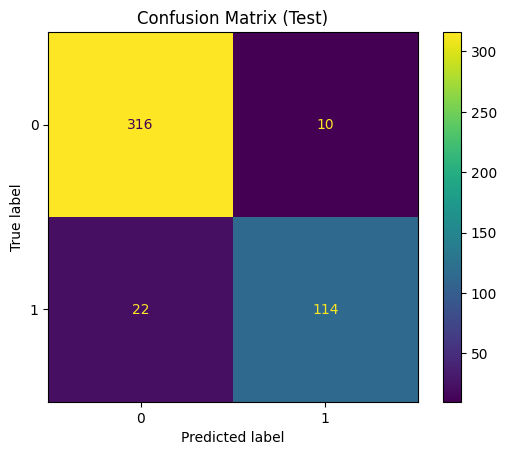

In [13]:

# Latih model
clf.fit(X_train, y_train)

# Prediksi di test
y_pred = clf.predict(X_test)

# Metrik
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (test): {acc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix (plot)
fig = plt.figure()
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix (Test)")
plt.show()



## 7) Ekspor `dataset_test.csv` & `model.pkl`
- `dataset_test.csv` berisi fitur **+** kolom target **asli** untuk data **test**  
- `model.pkl` adalah pipeline yang sudah terlatih (bisa dipakai untuk prediksi baru)


In [14]:

# Simpan dataset_test.csv
test_df = X_test.copy()
test_df[true_target] = y_test.values
test_csv_path = Path("dataset_test.csv")
test_df.to_csv(test_csv_path, index=False)

# Simpan model.pkl
model_path = Path("model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(clf, f)

print("Tersimpan:", test_csv_path.resolve())
print("Tersimpan:", model_path.resolve())


Tersimpan: D:\Personal\Kuliah\SEMESTER 5\ML (Prak)\Week7\dataset_test.csv
Tersimpan: D:\Personal\Kuliah\SEMESTER 5\ML (Prak)\Week7\model.pkl



## 🎯 Tips & Next Steps
- Coba ubah `CRITERION`, `MAX_DEPTH`, `MIN_SAMPLES_SPLIT` untuk melihat pengaruhnya pada akurasi.
- Gunakan `train_test_split(test_size=0.3)` untuk proporsi uji 30%.
- Jika hasil **overfitting** (train sangat bagus tapi test jelek), coba **batasi `max_depth`** (misal 4–10).
- Untuk menyimpan **graf** pohonnya, bisa gunakan `sklearn.tree.plot_tree` (opsional).

Butuh versi **Streamlit**? Kamu bisa pakai file `app.py` yang sudah kubuat sebelumnya.
